In [1]:
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatterSciNotation,LogLocator
%matplotlib inline

In [2]:
data = []
for metric_name in ['DiceAccuracy(threshold=0.5,smoothing=1)','DiceLoss(smoothing=1)']:
    table = []
    for csv_path in pathlib.Path(metric_name).rglob('*.csv'):
        metric_name,model_name,is_pretrained,purpose,csv_name = csv_path.as_posix().split('/')
        df = pd.read_csv(csv_path)
        df['ModelName'] = model_name
        df['IsPretrained'] = is_pretrained
        df['Purpose'] = purpose
        df['TrialNumber'] = csv_name.replace(f'_{purpose}','_').split('_')[-2]
        df = df.rename({'Step':'ImagesCount'},axis='columns')
        df = df.rename({'Value':metric_name},axis='columns')
        df = df.drop('Wall time',axis='columns')
        table.append(df)
    data.append(pd.concat(table).set_index(['ImagesCount','ModelName','IsPretrained','Purpose','TrialNumber']))
data = pd.concat(data,axis='columns')
data = data.reset_index()
data = data.replace({'Purpose':{'validation_wo_arg':'validation_w/o_arg'}})
data = data.replace({'IsPretrained':{'Pretrained':'pretrained','NonPretrained':'non-pretrained'}})
data = data.loc[~data['TrialNumber'].isin(f'{x:0>2}' for x in range(11,21))]
# data = data.query('ModelName != "AttDs"')

images_count_to_epoch = {i:e+1 for e,i in enumerate(sorted(data['ImagesCount'].value_counts(ascending=False)[:30].index))}
data = data.loc[data['ImagesCount'].isin(images_count_to_epoch.keys())]
data.insert(0,'Epoch',data['ImagesCount'].replace(images_count_to_epoch))
data = data.drop('ImagesCount',axis='columns')

In [18]:
def draw_pointplot(
    x,
    y,
    data,
    hue,
    legend_fontsize=None,
    logy=False,
    ylim=None):
    ax = sns.pointplot(
        x=x,
        y=y,
        data=data,
        dodge=True,
        hue=hue)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    if ylim != None:
        ax.set_ylim(ylim)
    if logy:
        ax.set_yscale("log")
        ax.yaxis.set_minor_locator(LogLocator(subs=(2,4,6,8)))
        ax.yaxis.set_minor_formatter(LogFormatterSciNotation(labelOnlyBase=False,minor_thresholds=(np.inf, np.inf)))
        ax.yaxis.grid(True,which='minor')
    plt.legend(title='',fontsize=legend_fontsize)
    
def draw_lineplot(
    x,
    y,
    data,
    hue,
    units,
    legend_fontsize=None,
    logy=False,
    ylim=None):
    ax = sns.lineplot(
        x=x,
        y=y,
        data=data,
        hue=hue,
        units=units,
        estimator=None)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    if ylim != None:
        ax.set_ylim(ylim)
    if logy:
        ax.set_yscale("log")
        ax.yaxis.set_minor_locator(LogLocator(subs=(2,4,6,8)))
        ax.yaxis.set_minor_formatter(LogFormatterSciNotation(labelOnlyBase=False,minor_thresholds=(np.inf, np.inf)))
        ax.yaxis.grid(True,which='minor')
    plt.legend(title='',fontsize=legend_fontsize)

def draw_boxplot(
    x,
    y,
    data,
    hue=None,
    legend_title=None,
    legend_fontsize=None,
    logy=False,
    ylim=None):
    
    
    if hue == None:
        hue_order = None
    else:
        if isinstance(hue,str):
            hue = [hue]
        hue = data[hue].apply(lambda x: ' '.join(x),axis=1)
        hue_order = sorted(hue.unique())
        
    sns.stripplot(
        x=x,
        y=y,
        hue=hue,
        hue_order = hue_order,
        data=data,
        dodge=True,
        edgecolor='black',
        linewidth=0.5)
        
    sns.boxplot(
        x=x,
        y=y,
        hue=hue,
        hue_order = hue_order,
        data=data,
        showfliers=False,
        showmeans=True,
        meanline=True,
        meanprops={'color': 'k'})
        
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:len(handles)//2], labels[:len(labels)//2],title=legend_title,fontsize=legend_fontsize)
    plt.grid(True,'major','x')
    plt.grid(True,'major','y')
    if ylim != None:
        plt.ylim(ylim)
    if logy:
        plt.yscale("log")
        plt.grid(True,'minor','y')

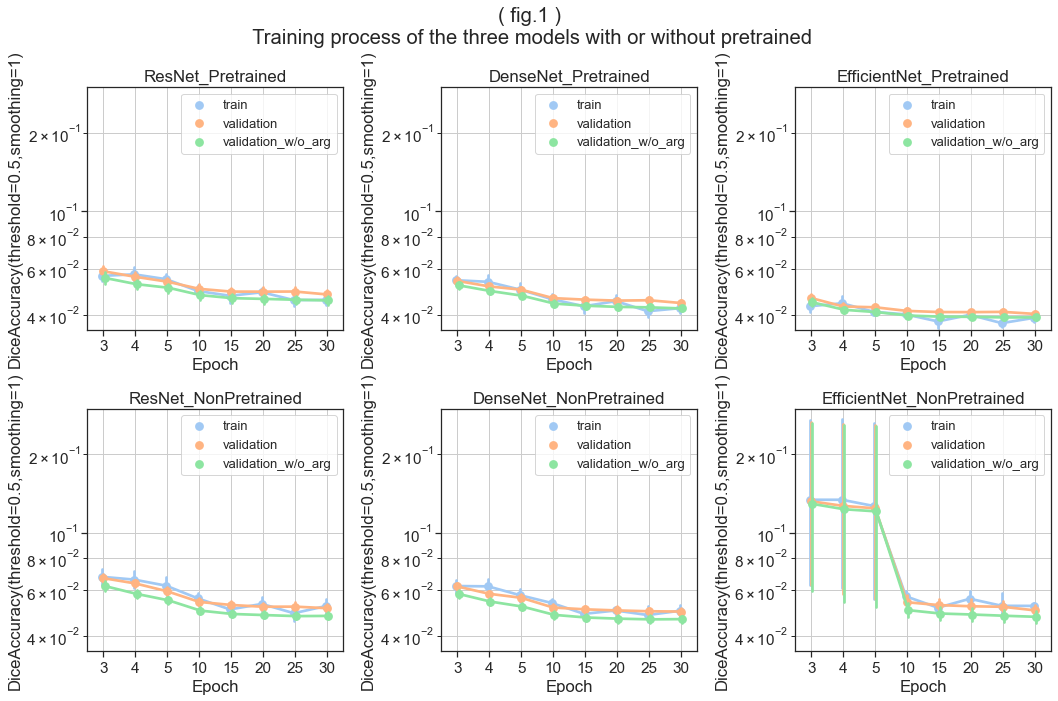

In [45]:
sns.set_theme(style="ticks", palette="pastel",font_scale = 1.4)

ylim=(0.035,0.3)
logy=True
legend_fontsize = 13

f, ax = plt.subplots(2,3,figsize=(15,10))
f.suptitle('( fig.1 )\n Training process of the three models with or without pretrained')

for a in ax.flatten():
    a.set_axis_off()

for i,modelname in enumerate(['ResNet','DenseNet','EfficientNet']):
    ax = f.add_subplot(2,3,i+1)
    ax.set_title(modelname+'_Pretrained')
    draw_pointplot(
        x='Epoch',
        y='DiceAccuracy(threshold=0.5,smoothing=1)',
        data=data.loc[data['Epoch'].isin([3,4]+list(range(5,31,5)))].query(f"ModelName=='{modelname}'&IsPretrained=='pretrained'"),
        hue='Purpose',
        logy=logy,
        ylim=ylim,
        legend_fontsize=legend_fontsize)

    ax = f.add_subplot(2,3,i+4)
    ax.set_title(modelname+'_NonPretrained')
    draw_pointplot(
        x='Epoch',
        y='DiceAccuracy(threshold=0.5,smoothing=1)',
        data=data.loc[data['Epoch'].isin([3,4]+list(range(5,31,5)))].query(f"ModelName=='{modelname}'&IsPretrained=='non-pretrained'"),
        hue='Purpose',
        logy=logy,
        ylim=ylim,
        legend_fontsize=legend_fontsize)

plt.tight_layout()
plt.show()

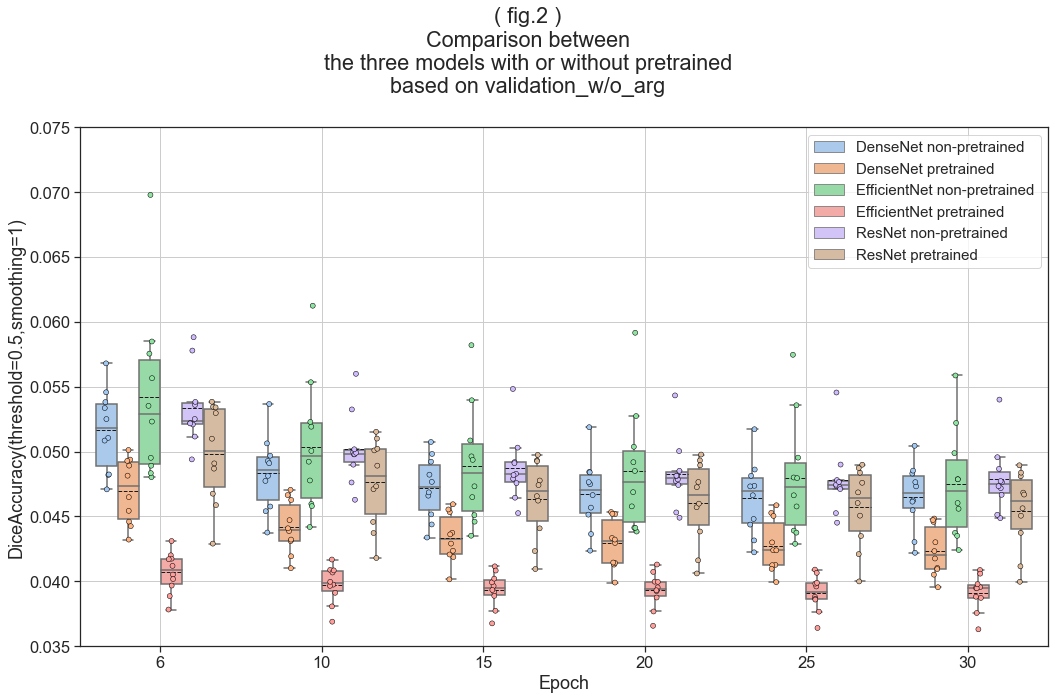

In [44]:
sns.set_theme(style="ticks", palette="pastel",font_scale=1.5)

ylim=(0.035,0.075)
logy=False
legend_fontsize=15

f, ax = plt.subplots(figsize=(15,10))
f.suptitle('( fig.2 )\n Comparison between \n the three models with or without pretrained \nbased on validation_w/o_arg')

draw_boxplot(
    x='Epoch',
    y='DiceAccuracy(threshold=0.5,smoothing=1)',
    data=data.loc[data['Epoch'].isin([6]+list(range(10,31,5)))].query("Purpose=='validation_w/o_arg'&ModelName!='AttDs'"),
    hue=['ModelName','IsPretrained'],
    logy=logy,
    ylim=ylim,
    legend_fontsize=legend_fontsize)

plt.tight_layout()

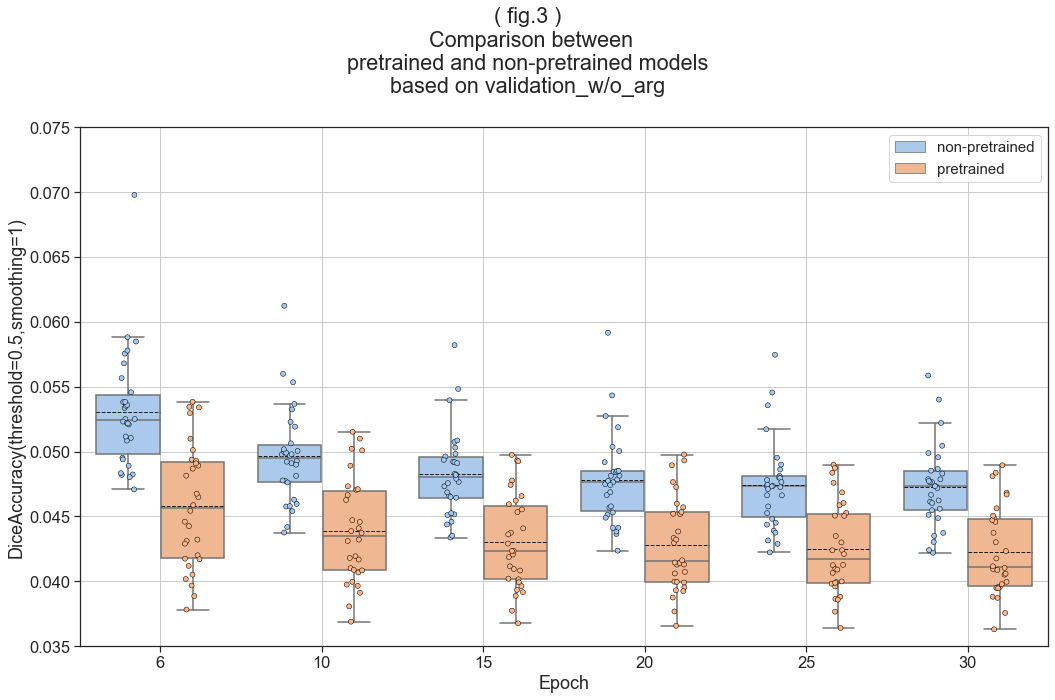

In [38]:
sns.set_theme(style="ticks", palette="pastel",font_scale=1.5)

ylim=(0.035,0.075)
logy=False
legend_fontsize=15

f, ax = plt.subplots(figsize=(15,10))
f.suptitle('( fig.3 )\n Comparison between\n pretrained and non-pretrained models \nbased on validation_w/o_arg')

draw_boxplot(
    x='Epoch',
    y='DiceAccuracy(threshold=0.5,smoothing=1)',
    data=data.loc[data['Epoch'].isin([6]+list(range(10,31,5)))].query("Purpose=='validation_w/o_arg'&ModelName!='AttDs'"),
    hue=['IsPretrained'],
    logy=logy,
    ylim=ylim,
    legend_fontsize=legend_fontsize)

plt.tight_layout()

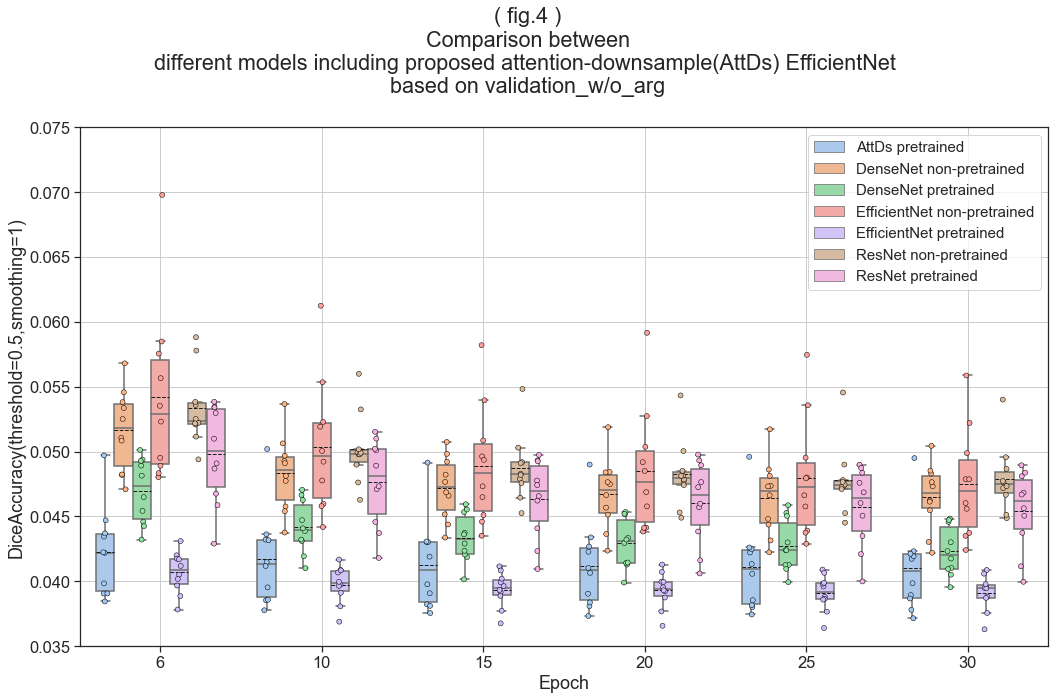

In [47]:
sns.set_theme(style="ticks", palette="pastel",font_scale=1.5)

ylim=(0.035,0.075)
logy=False
legend_fontsize=15

f, ax = plt.subplots(figsize=(15,10))
f.suptitle('( fig.4 )\n Comparison between \ndifferent models including proposed attention-downsample(AttDs) EfficientNet \nbased on validation_w/o_arg')

draw_boxplot(
    x='Epoch',
    y='DiceAccuracy(threshold=0.5,smoothing=1)',
    data=data.loc[data['Epoch'].isin([6]+list(range(10,31,5)))].query("Purpose=='validation_w/o_arg'"),
    hue=['ModelName','IsPretrained'],
    logy=logy,
    ylim=ylim,
    legend_fontsize=legend_fontsize)

plt.tight_layout()

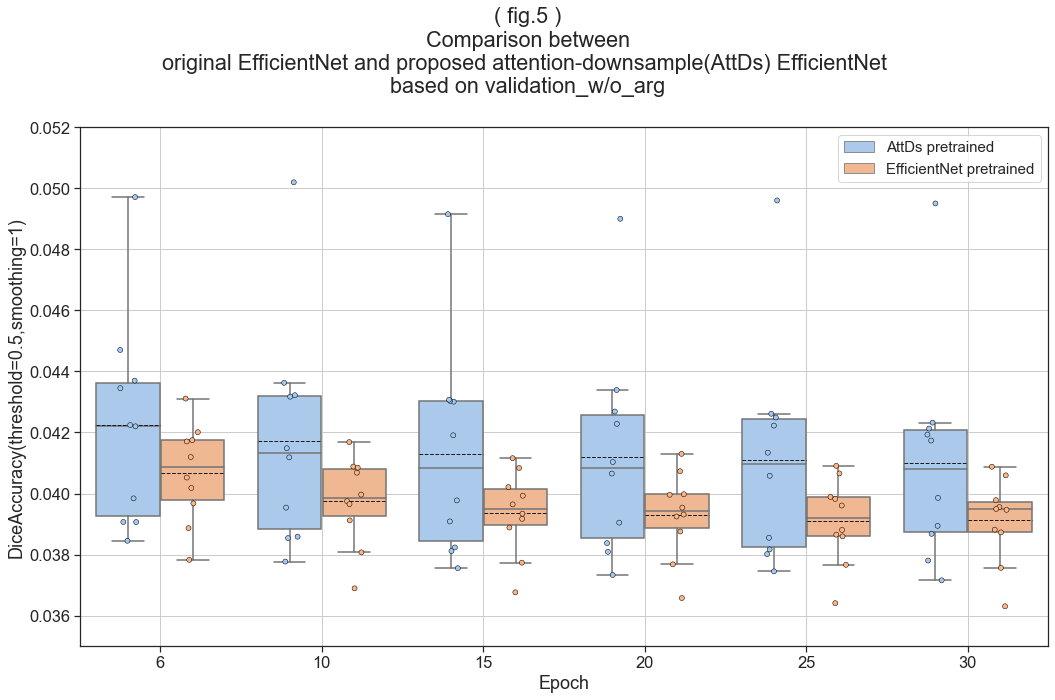

In [48]:
sns.set_theme(style="ticks", palette="pastel",font_scale=1.5)

ylim=(0.035,0.052)
logy=False
legend_fontsize=15

f, ax = plt.subplots(figsize=(15,10))
f.suptitle('( fig.5 )\n Comparison between \noriginal EfficientNet and proposed attention-downsample(AttDs) EfficientNet \nbased on validation_w/o_arg')

draw_boxplot(
    x='Epoch',
    y='DiceAccuracy(threshold=0.5,smoothing=1)',
    data=data.loc[data['Epoch'].isin([6]+list(range(10,31,5)))&data['ModelName'].isin(['AttDs','EfficientNet'])].query("Purpose=='validation_w/o_arg'&IsPretrained=='pretrained'"),
    hue=['ModelName','IsPretrained'],
    logy=logy,
    ylim=ylim,
    legend_fontsize=legend_fontsize)

plt.tight_layout()